### 유사도검정을 위한 EDA

가설
1. 카테고리별 청원동의수의 분포를 확인한다.  
2. 적절한 형태소 분석기를 선택한다.
3. 불용어를 처리한다
4. 토픽모델링 적용 후 카테고리별 청원동의 수 분포를 확인한다.

* 띄어쓰기를 제대로 하지 않은 경우는 맞춤법 검사를 해야할까?-> 시간이 오래걸림.
* 유사도 분석을 위해서는 실시간 대응이 되어야함. 

In [2]:
import pandas as pd
import re
from datetime import datetime

from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from konlpy.tag import Komoran

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

data = pd.read_pickle("../../petition/petition_total_data.pkl")

In [3]:
data_add = pd.read_excel("../../petition/add_data_0414.xlsx")

In [4]:
data = pd.concat([data,data_add], axis = 0)

In [5]:
data.shape

(40846, 11)

In [6]:
data = data.reset_index(drop=True)
data.shape

(40846, 11)

In [7]:
data['sdays'] = pd.to_datetime(data['sdays'])
data['edays'] = pd.to_datetime(data['edays'])

data['count'] = pd.to_numeric(data['count'])

2019년 3월 31일 이후 SNS 계정에서 100명 이상의 동의를 받은 후에만 청원 글을 게시할 수 있으므로 분석 대상은 청원 동의수가 100 이상인 게실글을 대상으로 한다.

In [8]:
data = data[data['sdays']>=datetime.strptime("2019.04.01", "%Y.%m.%d")]
data = data[data['sdays']<datetime.strptime("2021.04.01", "%Y.%m.%d")]

In [9]:
data['sdays'].max()

Timestamp('2021-03-31 00:00:00')

In [10]:
data = data[data['count']>= 100]

In [11]:
print(data.shape)

(17837, 11)


### 중복청원 제거

In [12]:
data = data.drop_duplicates(['title'])

In [13]:
data.shape

(17777, 11)

Text(0.5, 1.0, '청원동의수 분포')

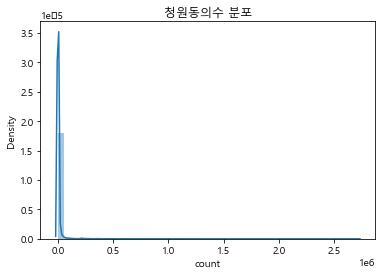

In [14]:
import warnings
warnings.filterwarnings('ignore')

sns.distplot(data['count'], hist=True, kde=True)
plt.title("청원동의수 분포")

In [15]:
print(f" 가장 많은 동의 수 {data['count'].max()}, 가장 적은 동의 수 {data['count'].min()}")

 가장 많은 동의 수 2715626.0, 가장 적은 동의 수 107.0


### 카테고리별 청원동의 수

Text(0.5, 1.0, '카테고리별 청원동의 수')

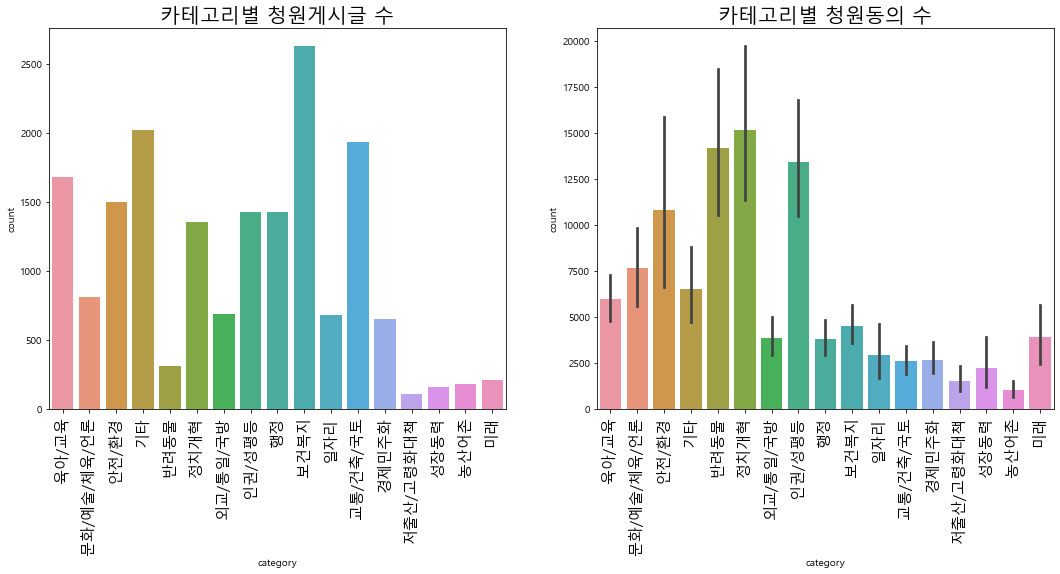

In [16]:
# plt.figure(figsize=(20,12))  # 도화지 만들기 
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)  # 공간 만들기 
fig.set_size_inches(18,7)

sns.countplot(data['category'], ax = ax1)
sns.barplot(data['category'], data['count'], ax = ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90,fontsize = 15)
ax1.set_title("카테고리별 청원게시글 수", fontsize = 20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontsize = 15)
ax2.set_title("카테고리별 청원동의 수", fontsize = 20)


카테고리별 청원게시글 수 는 '보건복지'가 2,097개로가장 많지만 카테고리별 청원동의수에서는 '정치개혁'이 가장 많고'반려동물', '인권/성평등' 순으로 많다. 

In [17]:
means = round(data.groupby(['category'])['count'].mean(),2)

pd.concat([pd.DataFrame(means), pd.DataFrame(data['category'].value_counts())], axis = 1).sort_values('count', ascending=False)

,count,category
정치개혁,15180.51,1358
반려동물,14190.37,312
인권/성평등,13434.16,1427
안전/환경,10798.84,1501
문화/예술/체육/언론,7633.16,813
기타,6530.88,2020
육아/교육,5956.85,1678
보건복지,4499.66,2628
미래,3877.71,210
외교/통일/국방,3871.65,687


하지만 게시글을 확인해보면 잘못 입력된 카테고리도 있기 때문에 토픽모델링을 통해 보다 정확하고 세부적으로 유형을 나눠 유사도 검정에 사용하고자 한다.

### 불용어 제외하기

국민청원 글이기 때문에 대통령, 국민청원, 청와대와 같은 공통적으로 발생할 수 있는 단어는 제외한다.   
또한, 반대합니다, 찬성합니다, 동의합니다, 동참합니다와 같은 청원글은 분석에서 제외한다.
이모지, URL 관련 단어들은 제외한다.

### 형태소 분석기 고르기

게시글은 띄어쓰기가 잘못된 경우가 많다. 띄어쓰기와 고유명사/일반명사를 잘 구분해내는 형태소 분석기를 사용할 것이다.
Okt, Hannaum 분석기는 고유명사를 잘 골라내지 못하고 꼬꼬마는 띄어쓰기가 안된 글의 길이가 너무 긴 경우 형태소를 분석하지 못하고 빈 리스트를 반환하므로 komoran을 사용한다. 

In [47]:
stop_words = ['자','쇼','소','점','대','이외','외','등','년','룰라랄라','개월','은','는','이','가','년','님',
              '부','등','수','밖','중','외','장','보','부','청원','대통령','국민청원','청와대'
             '개','이','저','게','지금','때문','이번','라고','이도','그']

emoji_pattern = re.compile("["
        u"\U0001F000-\U0001FFFF"  # 1F000~1FFFF 추가 
        u"\U000F0800-\U000F0855"               "]+", flags=re.UNICODE)

delete_pattern = ['\n','\t','\r', '대통령', '국민청원', '청원', '청와대', '관련링크와같이 글을 작성하였습니다',
                  'https?://[A-Za-z0-9./-]+',u'\xa0',u'\x0b']

delete_pattern2 = "[본 게시물의 일부 내용이 국민 청원 요건에 위배되어 관리자에 의해 수정되었습니다]"

data['content'] = [emoji_pattern.sub(r'', content) for content in data['content']]
data['content'] = [re.sub('|'.join(delete_pattern),u' ',''.join(content)).strip().replace(delete_pattern2," ") for content in data['content']]
data = data[~data['content'].isin(['반대합니다','찬성합니다','동의합니다','동참합니다'])]

In [51]:
data['doc_len'] = data['content'].map(lambda x: len(x))
print(data['doc_len'].min())
print(data['doc_len'].max())

0
57299


In [61]:
data = data[data['doc_len']!=0]

In [62]:
komoran = Komoran()
doc_nouns_list = [' '.join(komoran.nouns(doc)) for doc in data['content']]

In [65]:
# pd.DataFrame(doc_nouns_list).to_pickle("doc_nouns_list.pkl")

중요한 단어에 가중치를 주는 TF-IDF를 이용하여 문서단어행렬을 만든다.

In [18]:
doc_nouns_list = pd.read_pickle("doc_nouns_list.pkl")

In [19]:
data_words = [list(d)[0].split(" ") for d in doc_nouns_list.values]

In [20]:
# Gensim
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['정부', '아이돌_봄_서비스', '아이돌_보미', '영유아', '폭행', '처벌', '재발_방지', '방안', '수립', '부탁', '안녕하세요', '정부', '제공', '아이돌_봄_서비스', '이용', '중', '금천구', '개월', '아기', '맞벌이_부부', '건강_보험료', '부부_합산', '기준', '초과', '이유', '지원', '형', '이용', '지원', '정부', '소개', '돌_보미', '선생님', '이용', '하지', '개월', '아이', '개월', '지속', '학대', 'CCTV', '확인', '폭행', '영상', '아래_링크', '확인', '주시_길', '폭행', '내용', '다음', '따귀', '밥', '아이', '아파서', '울면', '입', '밥', '밀어', '밥', '아기', '재채기', '밥', '풀이', '유로', '아이', '소리', '뿐', '아기', '자', '방', '뒤통수', '머리채', '발_차고', '따귀', '등', '갖가지', '폭언_폭행', '확인', '현재', '부부', '사과문', '전달', '아이돌_보미', '부부', '아이', '이번', '일', '자신', '해고', '6년', '노고', '물거품', '말', '화가', '아이', '정도', '학대', '사람', '이', '6년', '아이돌_봄', '선생님', '활동', '게', '소름', '조금', '발견', '아이', '큰일', '수', '사건', '개월', '기간', '동안', '말', '학대', '14', '개월', '아이', '생각', '눈물', '아이돌_봄_서비스', '돌_봄이_필요', '가정', '시간', '서비스', '아동', '안전', '서비스', '사이트', '소개', '뿐', '맞벌이_부부', '사용', '정부', '지원', '서비스', '하지', '아이돌_봄_서비스', '이용', '아기', '안전', '보장', '부실', '부분', '관련', '아래', '제도', '보완', '필요', '생각', '영유아', '학대', '처벌'

In [21]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


stop_words = ['자','쇼','소','점','대','이외','외','등','년','룰라랄라','개월','은','는','이','가','년','님',
              '부','등','수','밖','중','외','장','보','부','청원','대통령','국민청원','청와대'
             '개','이','저','게','지금','때문','이번','라고','이도','그']

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


In [22]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


In [23]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 2), (4, 3), (5, 1), (6, 7), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 3), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 4), (27, 3), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 2), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 4), (43, 1), (44, 1), (45, 1), (46, 5), (47, 1), (48, 1), (49, 1), (50, 7), (51, 1), (52, 1), (53, 8), (54, 1), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 3), (66, 8), (67, 4), (68, 2), (69, 2), (70, 1), (71, 1), (72, 4), (73, 1), (74, 1), (75, 1), (76, 3), (77, 1), (78, 4), (79, 1), (80, 2), (81, 12), (82, 9), (83, 1), (84, 1), (85, 3), (86, 1), (87, 1), (88, 2), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 4), (95, 1), (96, 2), (97, 3), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 7), (109, 1), (110, 2

In [24]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('14', 1),
  ('6년', 2),
  ('CCTV', 1),
  ('가정', 2),
  ('강화', 3),
  ('갖가지', 1),
  ('개월', 7),
  ('개인', 1),
  ('건강', 1),
  ('검사', 1),
  ('것', 2),
  ('게', 1),
  ('곳', 1),
  ('관련', 1),
  ('교육', 2),
  ('국민', 1),
  ('금천구', 1),
  ('기간', 3),
  ('기준', 1),
  ('길', 1),
  ('내용', 1),
  ('노고', 1),
  ('노력', 1),
  ('눈물', 1),
  ('눈치', 1),
  ('다음', 1),
  ('돌', 4),
  ('동안', 3),
  ('뒤통수', 1),
  ('등', 1),
  ('따귀', 2),
  ('링크', 1),
  ('만', 1),
  ('말', 2),
  ('맞벌이', 2),
  ('머리채', 1),
  ('무상', 1),
  ('물거품', 1),
  ('밀어', 1),
  ('반복', 1),
  ('발', 1),
  ('발견', 1),
  ('밥', 4),
  ('방', 1),
  ('방안', 1),
  ('방지', 1),
  ('보미', 5),
  ('보완', 1),
  ('보장', 1),
  ('보험료', 1),
  ('봄', 7),
  ('봄이', 1),
  ('부모', 1),
  ('부부', 8),
  ('부분', 1),
  ('부실', 1),
  ('부탁', 1),
  ('불임', 1),
  ('뿐', 2),
  ('사건', 1),
  ('사과문', 1),
  ('사람', 1),
  ('사용', 1),
  ('사유', 1),
  ('사이트', 1),
  ('생각', 3),
  ('서비스', 8),
  ('선생님', 4),
  ('설치', 2),
  ('소개', 2),
  ('소름', 1),
  ('소리', 1),
  ('수', 4),
  ('수립', 1),
  ('시', 1),
  ('시간', 1),
  ('신청', 3),
 

In [64]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [72]:
print(lda_model.print_topics(),'\n')
doc_lda = lda_model[corpus]

[(0, '0.057*"정부" + 0.055*"시장" + 0.041*"기업" + 0.035*"정책" + 0.030*"투자" + 0.026*"거래" + 0.022*"공급" + 0.022*"산업" + 0.021*"가격" + 0.020*"경제"'), (1, '0.102*"사고" + 0.066*"차" + 0.063*"차량" + 0.056*"안전" + 0.043*"보험" + 0.024*"버스" + 0.024*"화재" + 0.023*"입주민" + 0.021*"현장" + 0.019*"발생"'), (2, '0.134*"병원" + 0.065*"환자" + 0.056*"의사" + 0.055*"검사" + 0.053*"치료" + 0.038*"의료" + 0.037*"수술" + 0.034*"확진" + 0.026*"입원" + 0.025*"간호사"'), (3, '0.087*"피해자" + 0.069*"가해자" + 0.061*"사건" + 0.037*"처벌" + 0.036*"피해" + 0.026*"폭행" + 0.025*"경찰" + 0.025*"폭력" + 0.025*"신고" + 0.018*"영상"'), (4, '0.043*"방역" + 0.039*"한국" + 0.032*"19" + 0.027*"금지" + 0.027*"자" + 0.026*"백신" + 0.023*"국민" + 0.022*"중국" + 0.021*"대한민국" + 0.018*"세계"'), (5, '0.050*"수사" + 0.040*"사건" + 0.038*"것" + 0.033*"경찰" + 0.032*"검찰" + 0.025*"사기" + 0.023*"증거" + 0.021*"검사" + 0.015*"범죄" + 0.015*"씨"'), (6, '0.061*"것" + 0.053*"수" + 0.015*"등" + 0.013*"상황" + 0.010*"지원" + 0.010*"국가" + 0.010*"문제" + 0.009*"정부" + 0.009*"년" + 0.009*"필요"'), (7, '0.117*"국민" + 0.031*"님" + 0.025*"대한민국" + 0.02

In [74]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.268073772170379

Coherence Score:  0.545409928257634


In [77]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\a0105\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.181543 -0.069584       1        1  18.214188
15     0.236113 -0.053456       2        1  12.665395
14     0.188726  0.066193       3        1  10.834290
16     0.220588 -0.023310       4        1  10.807804
11     0.101544 -0.178310       5        1   5.486985
9      0.058604  0.141622       6        1   5.079385
19     0.014904 -0.140589       7        1   4.884209
12     0.057020 -0.180245       8        1   4.716349
5      0.097525  0.260369       9        1   4.083767
4     -0.105868 -0.088931      10        1   3.890303
13    -0.049670 -0.123199      11        1   2.924257
7     -0.078764  0.029650      12        1   2.468872
0     -0.084653 -0.145237      13        1   2.466936
3      0.027603  0.260370      14        1   2.253204
2     -0.136636  0.042543      15        1   2.195770
10    -0.135882 -0.084598      16        1   1.907566
8     -0.149619  0.119848      17        1   1.675627
18    -0.015393  0.173485      18        1   1.444546
1     -0.159830 -0.044841      19        1   1.381061
17    -0.267855  0.038218      20        1   0.619487, topic_info=     Term          Freq         Total Category  logprob  loglift
15     국민  35768.000000  35768.000000  Default  30.0000  30.0000
10      것  93359.000000  93359.000000  Default  29.0000  29.0000
81     아이  14603.000000  14603.000000  Default  28.0000  28.0000
1154   병원  12537.000000  12537.000000  Default  27.0000  27.0000
61     사람  24533.000000  24533.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
1344   성인    259.125598    696.904073  Topic20  -4.6233   4.0947
1913   문화    335.998999   2956.835824  Topic20  -4.3635   2.9093
259    폐지    233.944801   1827.253891  Topic20  -4.7255   3.0285
1177    여    236.154548   2024.036771  Topic20  -4.7161   2.9357
784    인권    224.042985   2579.035889  Topic20  -4.7688   2.6407

[1192 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1126      5  0.278489   !!
1126      7  0.127410   !!
1126     10  0.101727   !!
1126     11  0.491511   !!
1127      5  0.303382  !!!
...     ...       ...  ...
3171      8  0.044887    힘
3171      9  0.007681    힘
3171     11  0.003601    힘
3171     12  0.076092    힘
3171     18  0.047768    힘

[2354 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 16, 15, 17, 12, 10, 20, 13, 6, 5, 14, 8, 1, 4, 3, 11, 9, 19, 2, 18])

In [ ]:
'''
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path= '../../mallet-2.0.8' # update this path
# from gensim.models.wrappers import LdaMallet

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

# Show Topics
print(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)
'''

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=17, limit=40, step=1)

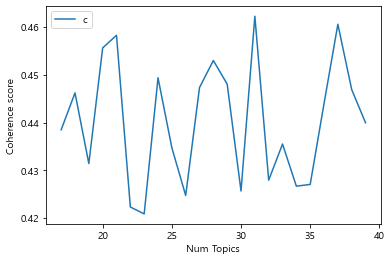

In [28]:
# Show graph
limit=40; start=17; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 17  has Coherence Value of 0.4385
Num Topics = 18  has Coherence Value of 0.4462
Num Topics = 19  has Coherence Value of 0.4314
Num Topics = 20  has Coherence Value of 0.4556
Num Topics = 21  has Coherence Value of 0.4583
Num Topics = 22  has Coherence Value of 0.4223
Num Topics = 23  has Coherence Value of 0.4209
Num Topics = 24  has Coherence Value of 0.4494
Num Topics = 25  has Coherence Value of 0.4347
Num Topics = 26  has Coherence Value of 0.4247
Num Topics = 27  has Coherence Value of 0.4473
Num Topics = 28  has Coherence Value of 0.453
Num Topics = 29  has Coherence Value of 0.4481
Num Topics = 30  has Coherence Value of 0.4257
Num Topics = 31  has Coherence Value of 0.4623
Num Topics = 32  has Coherence Value of 0.4279
Num Topics = 33  has Coherence Value of 0.4355
Num Topics = 34  has Coherence Value of 0.4267
Num Topics = 35  has Coherence Value of 0.427
Num Topics = 36  has Coherence Value of 0.444
Num Topics = 37  has Coherence Value of 0.4606
Num Topics = 38 

In [ ]:
coherences=[]
perplexities=[]
passes=[]
warnings.filterwarnings('ignore')
import time

for i in range(9, 20):
    
    ntopics, nwords = 200, 100
    if i==0:
        p=1
    else:
        p=i*2
        
    tic = time.time()
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=ntopics, 
                                           random_state=20171490,
                                           update_every=1,
                                           chunksize=100,
                                           passes=p,
                                           alpha='auto',
                                           per_word_topics=True)
    
    print('epoch',p,time.time() - tic)
    # tfidf, corpus 무슨 차이?
    # lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=200000)

    cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherences.append(coherence)
    print('Perplexity: ', model.log_perplexity(corpus),'\n\n')
    perplexities.append(model.log_perplexity(corpus))

In [31]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=18))

[(0, '0.013*"것" + 0.010*"공무원" + 0.010*"등" + 0.008*"민원" + 0.008*"업무" + 0.007*"수" + 0.007*"사업" + 0.007*"내용" + 0.006*"조사" + 0.006*"조합원" + 0.006*"년" + 0.006*"관련" + 0.006*"사실" + 0.006*"처리" + 0.005*"조합" + 0.005*"해당" + 0.005*"관리" + 0.005*"일"'), (1, '0.032*"병원" + 0.017*"환자" + 0.017*"수" + 0.015*"의사" + 0.014*"것" + 0.014*"치료" + 0.011*"의료" + 0.010*"검사" + 0.010*"코로나" + 0.010*"수술" + 0.008*"확진" + 0.007*"후" + 0.007*"일" + 0.006*"입원" + 0.006*"간호사" + 0.006*"말" + 0.006*"상태" + 0.006*"상황"'), (2, '0.017*"수" + 0.016*"것" + 0.011*"지원" + 0.010*"지원금" + 0.009*"운영" + 0.009*"년" + 0.008*"지급" + 0.007*"등" + 0.007*"경우" + 0.006*"직원" + 0.006*"시설" + 0.006*"센터" + 0.005*"정부" + 0.005*"일" + 0.005*"기준" + 0.005*"영업" + 0.005*"고용" + 0.005*"자영업자"'), (3, '0.026*"코로나" + 0.020*"수" + 0.019*"것" + 0.015*"일" + 0.010*"사람" + 0.010*"마스크" + 0.010*"생각" + 0.009*"상황" + 0.009*"방역" + 0.008*"자" + 0.007*"시간" + 0.007*"분" + 0.006*"명" + 0.006*"금지" + 0.006*"확진" + 0.005*"말" + 0.005*"19" + 0.005*"안"'), (4, '0.036*"아이" + 0.020*"아이들" + 0.019*"것" + 0.017*"학교

In [32]:
pd.DataFrame(optimal_model.print_topics(num_words=18))

,0,1
0,0,"0.013*""것"" + 0.010*""공무원"" + 0.010*""등"" + 0.008*""민..."
1,1,"0.032*""병원"" + 0.017*""환자"" + 0.017*""수"" + 0.015*""의..."
2,2,"0.017*""수"" + 0.016*""것"" + 0.011*""지원"" + 0.010*""지원..."
3,3,"0.026*""코로나"" + 0.020*""수"" + 0.019*""것"" + 0.015*""일..."
4,4,"0.036*""아이"" + 0.020*""아이들"" + 0.019*""것"" + 0.017*""..."
5,5,"0.015*""법"" + 0.013*""법관"" + 0.013*""등"" + 0.012*""사건..."
6,6,"0.017*""마을"" + 0.016*""수"" + 0.014*""사고"" + 0.013*""도..."
7,7,"0.024*""것"" + 0.024*""학생"" + 0.023*""수"" + 0.013*""교육..."
8,8,"0.020*""것"" + 0.019*""사건"" + 0.013*""수"" + 0.013*""피해..."
9,9,"0.017*""것"" + 0.014*""주택"" + 0.013*""수"" + 0.009*""년""..."


In [106]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data.content.values.tolist())

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

C:\Users\a0105\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
from scipy.spatial.distance import jensenshannon


In [ ]:
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))
 
# calculate the js divergence
def js_divergence(p, q):
	m = 0.5 * (p + q)
	return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

### -----

In [67]:

tfidf_vectorizer = TfidfVectorizer(min_df=3, max_features=1500)  # 한 번만 나타나는 단어들은 무시

words = np.array(tfidf_vectorizer.get_feature_names())
words

NotFittedError: Vocabulary not fitted or provided

In [ ]:
import pandas as pd
pd.DataFrame(doc_nouns_list).to_pickle("doc_nouns_list.pkl")

In [1]:
from sklearn.decomposition import LatentDirichletAllocation

# Instantiate the LDA model
lda_model = LatentDirichletAllocation(n_components=35, max_iter=100, learning_method='online', random_state=43,
                                     batch_size=128, evaluate_every=-1, n_jobs=-1)

# fit transform the feature matrix
lda_output = lda_model.fit_transform(tfidf_matrix)


NameError: name 'tfidf_matrix' is not defined

In [58]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
id2word=id2word,
num_topics=20,
random_state=100,
update_every=1,
chunksize=100,
passes=10,
alpha='auto',
per_word_topics=True)

(17267, 1500)

In [ ]:

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.
 
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


In [23]:
# Build the bigram and trigram models
import gensim

bigram = gensim.models.Phrases(doc_nouns_list, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[doc_nouns_list], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [26]:
from gensim.utils import simple_preprocess

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [27]:
data_words_nostops = remove_stopwords(stop_words)

In [30]:
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_bigrams

[['이외',
  '룰라랄라',
  '개월',
  '청원',
  '대통령',
  '국민청원',
  '청와대개',
  '지금',
  '때문',
  '이번',
  '라고',
  '이도']]

In [31]:
data_words_nostops

[['이외',
  '룰라랄라',
  '개월',
  '청원',
  '대통령',
  '국민청원',
  '청와대개',
  '지금',
  '때문',
  '이번',
  '라고',
  '이도']]

In [430]:
from sklearn.decomposition import NMF

for topic_n in range(30,40):
    nmf = NMF(n_components=topic_n, solver="mu", random_state = 20171490)
    W = nmf.fit_transform(tfidf_matrix)  # 유사도 검정에 사용   # features matrix
    H = nmf.components_   #  토픽모델링에 사용 # component matrix

    print(topic_n,"\n")
    for i, topic in enumerate(H):
         print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-10:]]])))
            

30 

Topic 1: 바이러스,사람,방역,확산,정부,감염,상황,국민,19,코로나
Topic 2: 학년,아이들,교육부,교육,온라인,등교,개학,수업,학교,학생
Topic 3: 제가,학대,어린이집,아들,아빠,선생님,부모,엄마,아이들,아이
Topic 4: 서민,투기,아파트,분양,정책,대출,주택자,부동산,임대,주택
Topic 5: 법무부,검사,조국,국민,윤석열,개혁,장관,총장,수사,검찰
Topic 6: 정부,공적,구입,공급,착용,약국,가격,구매,판매,마스크
Topic 7: 성범죄,아버지,피해자들,경찰,피해,처벌,폭행,사건,피해자,가해자
Topic 8: 검사,요양,입원,진료,간호사,의료,환자,수술,의사,병원
Topic 9: 우리나라,정책,생각,국회,정부,국회의원,국가,나라,대한민국,국민
Topic 10: 자영업자,소득,만원,대출,공인,소상,재난,지원금,지급,지원
Topic 11: 환경,지역,부지,계획,허가,시설,개발,마을,사업,주민
Topic 12: 문제,공무원,수능,자격증,합격,연기,준비,응시,수험,시험
Topic 13: 대주주,거래,기업,개인,금융,투자,시장,투자자,주식,공매도
Topic 14: 해외,한국인,바이러스,외국인,우리나라,금지,중국인,한국,입국,중국
Topic 15: 신고,기관,범죄,성범죄,청소년,처벌,보호,사건,학대,아동
Topic 16: 운영,방역,단계,집합,자영업자,카페,금지,학원,시설,영업
Topic 17: 등록,처벌,입양,생명,학대,사람,유기,강아지,반려,동물
Topic 18: 경제,지원,제품,세계,운동,민족,전쟁,일제,역사,일본
Topic 19: 사람,군대,여자,인권,차별,사회,성범죄,가족,남성,여성
Topic 20: 노선,지정,재난,규제,경북,서울,조정,시민,대구,지역
Topic 21: 맞벌이,학부모,아이들,가정,원장,긴급,유치원,보육,어린이집,교사
Topic 22: 버스,도로,운행,운전,보험,자동차,안전,운전자,사고,차량
Topic 23: 자유,활동,단체,목사,협조,집단,대구,종교,교회,신천지
Topic 24: 문자,접촉,시민,자가,정보,

36 

Topic 1: 확진,확산,정부,생각,감염,상황,사람,19,국민,코로나
Topic 2: 학기,연기,교육부,아이들,온라인,학생,등교,수업,학교,개학
Topic 3: 학대,남편,어린이집,아들,아빠,선생님,부모,엄마,아이들,아이
Topic 4: 서민,규제,투기,주택자,정책,분양,아파트,대출,부동산,주택
Topic 5: 법무부,국민,검사,조국,윤석열,개혁,장관,총장,수사,검찰
Topic 6: 정부,공적,구입,공급,착용,약국,가격,구매,판매,마스크
Topic 7: 증거,피해자,제가,전화,사실,내용,수사,조사,경찰,사건
Topic 8: 수술,공공,파업,진료,병원,간호사,의대,환자,의료,의사
Topic 9: 경제,세계,북한,우리나라,정부,한국,국가,나라,대한민국,국민
Topic 10: 자영업자,만원,소득,대출,공인,소상,재난,지급,지원금,지원
Topic 11: 도로,허가,개발,아파트,시설,사업,지역,마을,공사,주민
Topic 12: 채용,공무원,수능,자격증,합격,연기,준비,응시,수험,시험
Topic 13: 대주주,기업,거래,개인,금융,투자,시장,투자자,주식,공매도
Topic 14: 격리,한국인,외국인,우리나라,바이러스,금지,한국,중국인,입국,중국
Topic 15: 범죄,피해,어린이집,기관,청소년,신고,사건,보호,학대,아동
Topic 16: 운영,방역,단계,자영업자,집합,카페,금지,학원,시설,영업
Topic 17: 등록,처벌,입양,생명,학대,유기,사람,강아지,반려,동물
Topic 18: 경제,세계,지원,제품,민족,전쟁,운동,일제,역사,일본
Topic 19: 군대,성범죄,생각,차별,여자,사회,가족,사람,남성,여성
Topic 20: 사람,서울,조정,확진,시장,재난,경북,시민,지역,대구
Topic 21: 맞벌이,학부모,아이들,가정,원장,긴급,유치원,보육,어린이집,교사
Topic 22: 버스,도로,운행,보험,운전,자동차,안전,운전자,사고,차량
Topic 23: 자유,활동,단체,협조,목사,집단,대구,종교,교회,신천지
Topic 24: 법인,대인,사업,혜택,임대료,임차인,등록

In [433]:
components_df = pd.DataFrame(H, columns=words)  # 토픽별 단어 특징

In [434]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
코로나    2.747777
사람     1.603122
국민     1.514880
19     1.375054
상황     1.089051
생각     1.003544
감염     0.906216
정부     0.821491
확진     0.716815
확산     0.678530
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
개학     2.125856
학교     1.798292
수업     1.767575
등교     1.259427
온라인    1.006647
학생     0.996343
아이들    0.839500
연기     0.640177
교육부    0.618117
학기     0.502318
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
아이     3.760072
아이들    1.157755
엄마     0.990731
부모     0.721396
선생님    0.576323
아들     0.511910
아빠     0.505853
남편     0.405054
제가     0.370167
생각     0.347903
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
주택     1.686345
부동산    1.440262
아파트    1.366191
분양     1.244853
정책     1.111645
대출     1.110236
주택자    1.064939
투기     0.951263
서민     0.846778
규제     0.813371
Name: 3, dtype: float64


For topic 5 the words with the highest value are:
검찰    

In [460]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(20, 2, figsize=(30, 100), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)  # 막대그래프 크기 
        ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 30})  # 각 그래프 별 title
        ax.invert_yaxis()   # 막대그래프 정렬 
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
             ax.spines[i].set_visible(False)  # 그래프 윤곽 없애기 
        fig.suptitle(title, fontsize=40)  # 전체 title

    plt.subplots_adjust(top=0.95, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

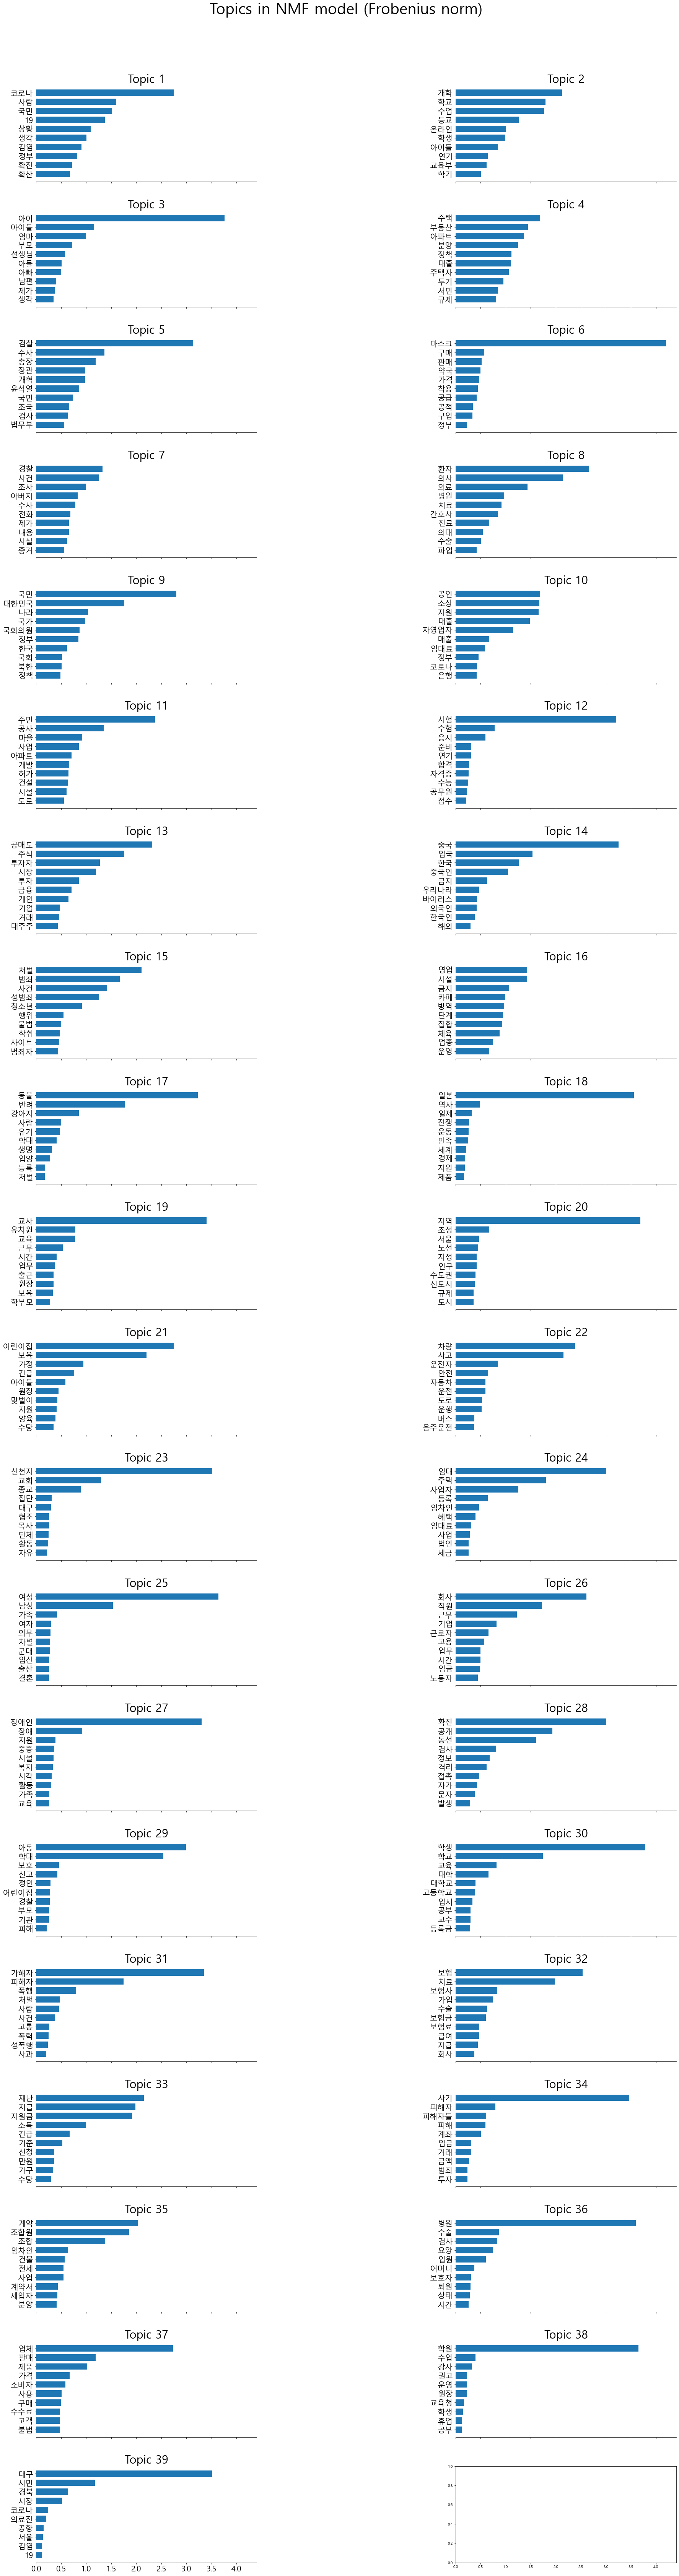

In [461]:
plot_top_words(nmf, words, 10,'Topics in NMF model (Frobenius norm)')

### LDA

In [464]:
from sklearn.decomposition import LatentDirichletAllocation

# Instantiate the LDA model
lda_model = LatentDirichletAllocation(n_components=35, max_iter=100, learning_method='online', random_state=43,
                                     batch_size=128, evaluate_every=-1, n_jobs=-1)

# fit transform the feature matrix
lda_output = lda_model.fit_transform(tfidf_matrix)

# display the lda_output and its shape
display(lda_output)
display(lda_output.shape)

array([[0.00469613, 0.08203933, 0.00469613, ..., 0.00469613, 0.00469613,
        0.00469613],
       [0.0077968 , 0.0077968 , 0.0077968 , ..., 0.0077968 , 0.0077968 ,
        0.0077968 ],
       [0.00383818, 0.86950205, 0.00383818, ..., 0.00383818, 0.00383818,
        0.00383818],
       ...,
       [0.00460242, 0.37723282, 0.00460242, ..., 0.00460242, 0.00460242,
        0.00460242],
       [0.00361762, 0.32146022, 0.00361762, ..., 0.00361767, 0.00361762,
        0.00361762],
       [0.0042365 , 0.0042365 , 0.0042365 , ..., 0.0042365 , 0.0042365 ,
        0.0042365 ]])

(15136, 35)

In [465]:
print("Log likelihood: ", lda_model.score(tfidf_matrix))

Log likelihood:  -684707.6423208846


In [466]:
print("Perplexity: ", lda_model.perplexity(tfidf_matrix))

Perplexity:  3703.389820120655


### LDA GridSearch

In [476]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': range(17,45), 'learning_decay': [.5, .7, .9]}

# Init the model
lda = LatentDirichletAllocation()

# Init Grid Search class
model = GridSearchCV(lda, search_params)

model.fit(tfidf_matrix)
best_lda_model = model.best_estimator_
print("Best model's params: ", model.best_params_)
print("Best log likelihood score: ", model.best_score_)
print("Model perplexity: ", best_lda_model.perplexity(tfidf_matrix))

C:\Users\a0105\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best model's params:  {'learning_decay': 0.9, 'n_components': 17}
Best log likelihood score:  -157322.3432151671
Model perplexity:  2850.114116543955


In [477]:
df_cv_results = pd.DataFrame(model.cv_results_)
df_cv_results.to_csv("LDAGridSearchResults.csv", header=True, index=False, encoding='utf-8')

C:\Users\a0105\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\a0105\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='param_n_components', ylabel='mean_test_score'>

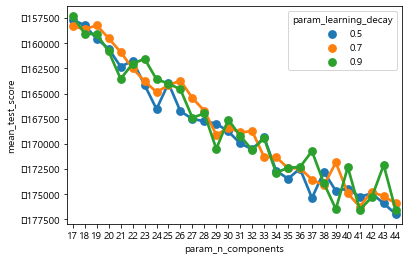

In [478]:
import seaborn as sns

sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay", data=df_cv_results)


In [ ]:
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

토픽 수를 늘릴수록 감소   
키워드와 대표문서들 간 연관성을 바탕으로 해석 가능한 토픽을 판별+전체 토픽 수 대비 해석 가능한 토픽 수의 비율 등을 바탕으로 토픽 수를 결정

In [479]:
best_lda_model

C:\Users\a0105\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(learning_decay=0.9, n_components=17)

In [480]:
lda_output = best_lda_model.transform(tfidf_matrix)  # Topic 행렬 생성 

C:\Users\a0105\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [481]:
# column names
topicnames = ['Topic_' + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ['Doc_' + str(i) for i in range(len(data))]

# create a dataframe
df_document_topic = pd.DataFrame(np.round(lda_output,2), columns=topicnames, index=docnames)

df_document_topic.head()

C:\Users\a0105\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: Shape of passed values is (15136, 17), indices imply (17267, 17)

In [482]:
# dominant topic
df_document_topic['dominant_topic'] = np.argmax(df_document_topic.values, axis=1)
df_document_topic.head()

C:\Users\a0105\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'LatentDirichletAllocation' object has no attribute 'values'

In [ ]:
sns.countplot(df_document_topic.dominant_topic)

In [483]:
import pyLDAvis.sklearn
panel = pyLDAvis.sklearn.prepare(best_lda_model, tfidf_matrix, tfidf_vectorizer, mds='tsne')
pyLDAvis.display(panel)

C:\Users\a0105\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sims = gensim.similarities.Similarity(tfidfA[corpusA], num_features=len(dictA))
sims[corpusB_tfidf]

In [471]:
panel = pyLDAvis.sklearn.prepare(lda_model, tfidf_matrix, tfidf_vectorizer, mds='PCoA')
pyLDAvis.display(panel)

C:\Users\a0105\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: Object of type complex is not JSON serializable

좌측 원들ㄹ은 각각의 토픽, 각 원과의 거리는 각 토픽들이 서로 얼마나 다른가? 2개의 원이 겹친다면 이 두 2개의 토픽은 유사한 토픽, 각 토픽에 대한 정보가 오른쪽 막대그래프에 나타남. 

### LDA
- 같은 클래스에 있느느 데이터들의 분산을 최대한 줄이고 각 데이터들의 평균 값들의 분산은 최대한 키워서 클래스들끼리 최대한 멀리 떨어지게 만드는 알고리즘

### 각 주제의 keyword 가져오기

In [ ]:
best_lda_model.components_.shape

In [ ]:
feature_matrix.shape

In [ ]:
# Topic - Keyword matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# assign column and index
df_topic_keywords.columns = count_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames


# check the head
df_topic_keywords.iloc[:,:10]

#### 상위 키워드 15개 가져오기

In [ ]:
# Show top n keywords for each topic
def show_topics(vectorizer=count_vectorizer, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [ ]:
topic_keywords = show_topics(count_vectorizer, best_lda_model, 20)
topic_keywords

In [ ]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

참고: https://lovit.github.io/nlp/2019/06/10/visualize_topic_models_with_pyldavis/#topic=0&lambda=1&term=

https://medium.com/ml2vec/topic-modeling-is-an-unsupervised-learning-approach-to-clustering-documents-to-discover-topics-fdfbf30e27df

https://wikidocs.net/30708  # LDA    
https://shravan-kuchkula.github.io/topic-modeling/#predict-topics-for-new-text

#### 딥러닝 예측에 사용

In [ ]:
data_10_0 = data_10[data_10['range']==0][0:1000]
data_10_no = data_10[data_10['range']!= 0 ]
total = pd.concat([data_10_0,data_10_no], axis = 0)
total = total.reset_index()

In [ ]:
total['range'].value_counts()

In [ ]:
total_data = total.drop(['range'],axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(total_data[['content']], total['range'], test_size=0.2, shuffle=True, stratify=total['range'], random_state=34)


In [ ]:
X_train = X_train.reset_index(drop= True) 

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

X_train['doc_len'] = X_train.content.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.doc_len.mean() + dataframe.doc_len.std()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{max_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    
    print(f" 가장 긴 문장은 {X_train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {X_train['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(X_train)

In [ ]:
max_length= 859

In [ ]:
X_train

In [ ]:
X_train[['content']]

In [ ]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train['content'])
sequences_train = tokenizer.texts_to_sequences(X_train['content'])
sequences_validation = tokenizer.texts_to_sequences(X_valid['content'])

In [ ]:
print(f"Original document: {X_train.values[0]} \nNumerical representation: {sequences_train[0]}")

In [ ]:
from keras.preprocessing import sequence
x_train=sequence.pad_sequences(sequences_train,maxlen=max_length)
x_validation=sequence.pad_sequences(sequences_validation,maxlen=max_length)
print(f"Train set shape: {x_train.shape}\nValidation set shape: {x_validation.shape}")

In [ ]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train_categorical=encoder.fit_transform(y_train.values.reshape(-1, 1))
y_validation_categorical=encoder.transform(y_valid.values.reshape(-1, 1))

In [ ]:
print(f"Train set labels: {y_train_categorical.__len__()}\nValidation set labels: {y_validation_categorical.__len__()}")


In [331]:
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential,optimizers
from keras_sequential_ascii import keras2ascii

class CNNtext(Sequential):
    """
    This class extends  keras.sequencial in order to build our 
    model according to the designed architecture
    """
    #params for the convolutional layers
    __num_filters = 64
    __weight_decay = 1e-4
    #optimizers
    __adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    def __init__(self,max_length,number_of_classes,embedding_matrix=None,vocab_size=None,tokenizer=None):
        #creating the model heritance from Keras.sequencial
        super().__init__()
        #params for the embedding layer
        self.__embedding_dim=100 if embedding_matrix is None else embedding_matrix.shape[1]
        #self.__vocab_size=vocab_size if tokenizer is None else tokenizer.word_index.__len__()+1
        self.__vocab_size=vocab_size if tokenizer is None else max(tokenizer.index_word.keys())+1
        try:
            self.__max_length=max_length
            self.__number_of_classes=number_of_classes 
        except NameError as error:
            print("Error ",error," must be defined.")
            
        #defining layers
        #This layer will learn an embedding the vocab_size is the vocabulary learn from our tokenizer
        #the embedding dimension is defined by our selfs in this case we choose a dimension of 100
        #the input length is the maximum length of the documents we will use
        if embedding_matrix is None:
            self.add(Embedding(self.__vocab_size,
                               self.__embedding_dim,
                               input_length=self.__max_length,trainable=True))
        else:
            self.add(Embedding(embedding_matrix.shape[0],
                               embedding_matrix.shape[1],
                               weights=[embedding_matrix],
                               input_length=self.__max_length,
                               trainable=False))
        #then we apply a 1D conv layer that should apply filters to the sequence and generate features maps.
        self.add(Conv1D(self.__num_filters, 7, activation='relu', padding='same'))
        #then we will get the most important features using a max pooling layer
        self.add(MaxPooling1D(2))
        #afterwards we apply a conv 1D layer to learn new features form the previous results
        self.add(Conv1D(self.__num_filters, 7, activation='relu', padding='same'))
        #we select again the most important features
        self.add(GlobalMaxPooling1D())
        #then we apply dropout to improve the generalization
        self.add(Dropout(0.5))
        #then we will pass the results into a dense layer that will also learn some internal representation and we also use the l2 regularization
        self.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(self.__weight_decay)))
        #for the final layer we will use softmax to obtain the probabilities of each class.
        self.add(Dense(self.__number_of_classes, activation='softmax'))  
        #to compute the loss function we use binary_crossentropy
        #which is widely used for multi-classification problems
        #we also use the adam optimazer to learn the parameters(weights)
        #and minimize the loss function.
        self.compile(loss='binary_crossentropy', optimizer=self.__adam, metrics=['accuracy'])     



In [332]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1)

In [333]:
#training params
batch_size = 64
num_epochs = 10

In [334]:
max_length

859

In [335]:
CNN_BOW=CNNtext(max_length,
              encoder.classes_.__len__(),
              tokenizer=tokenizer)

In [336]:
keras2ascii(CNN_BOW)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####         859
           Embedding   emb | -------------------  16853500    99.6%
                       #####    859  100
              Conv1D    \|/  -------------------     44864     0.3%
                relu   #####    859   64
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####    429   64
              Conv1D    \|/  -------------------     28736     0.2%
                relu   #####    429   64
  GlobalMaxPooling1D   Y^max -------------------         0     0.0%
                       #####          64
             Dropout    | || -------------------         0     0.0%
                       #####          64
               Dense   XXXXX -------------------      2080     0.0%
                relu   #####          32
               Dense   XXXXX -------------------       165     0.0%
             softmax   #####           5


In [337]:
x_train

array([[    0,     0,     0, ...,  1487, 12067,    59],
       [    0,     0,     0, ...,   451,   970,  7411],
       [    0,     0,     0, ..., 14213,   573,    59],
       ...,
       [    0,     0,     0, ..., 27222,  2713,    83],
       [    0,     0,     0, ...,  1826,   241,   844],
       [    0,     0,     0, ...,   156,   241,  5937]])

In [338]:
y_train_categorical

array([[1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0]])

In [339]:
hist = CNN_BOW.fit(x_train, y_train_categorical,
                 batch_size=batch_size, epochs=num_epochs, callbacks=[es],
                 validation_data=(x_validation,y_validation_categorical),
                 shuffle=True)

Epoch 1/10
31/31 [==============================] - 14s 395ms/step - loss: 0.6241 - accuracy: 0.3852 - val_loss: 0.4220 - val_accuracy: 0.4082
Epoch 2/10
31/31 [==============================] - 12s 388ms/step - loss: 0.4420 - accuracy: 0.4142 - val_loss: 0.3993 - val_accuracy: 0.4388
Epoch 3/10
31/31 [==============================] - 12s 391ms/step - loss: 0.4000 - accuracy: 0.4739 - val_loss: 0.3993 - val_accuracy: 0.4408
Epoch 4/10
31/31 [==============================] - 12s 393ms/step - loss: 0.3882 - accuracy: 0.5330 - val_loss: 0.3978 - val_accuracy: 0.4571
Epoch 00004: early stopping


In [340]:
def plot_model_perfomance(hist,name):
    plt.style.use('fivethirtyeight')
    plt.figure(1)
    plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend(loc='upper right')
    plt.figure(2)
    plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

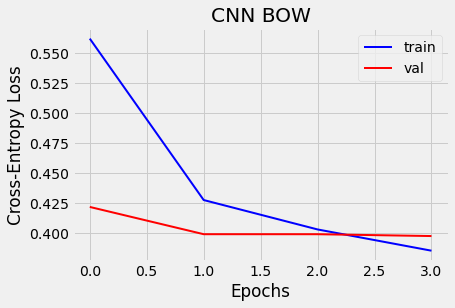

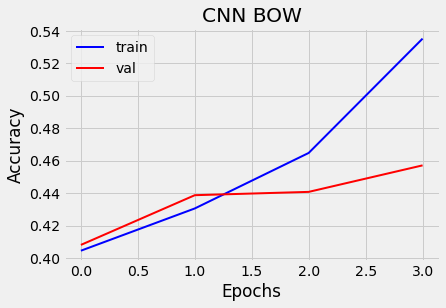

In [341]:
plot_model_perfomance(hist,'CNN BOW')


16/16 [==============================] - 1s 27ms/step


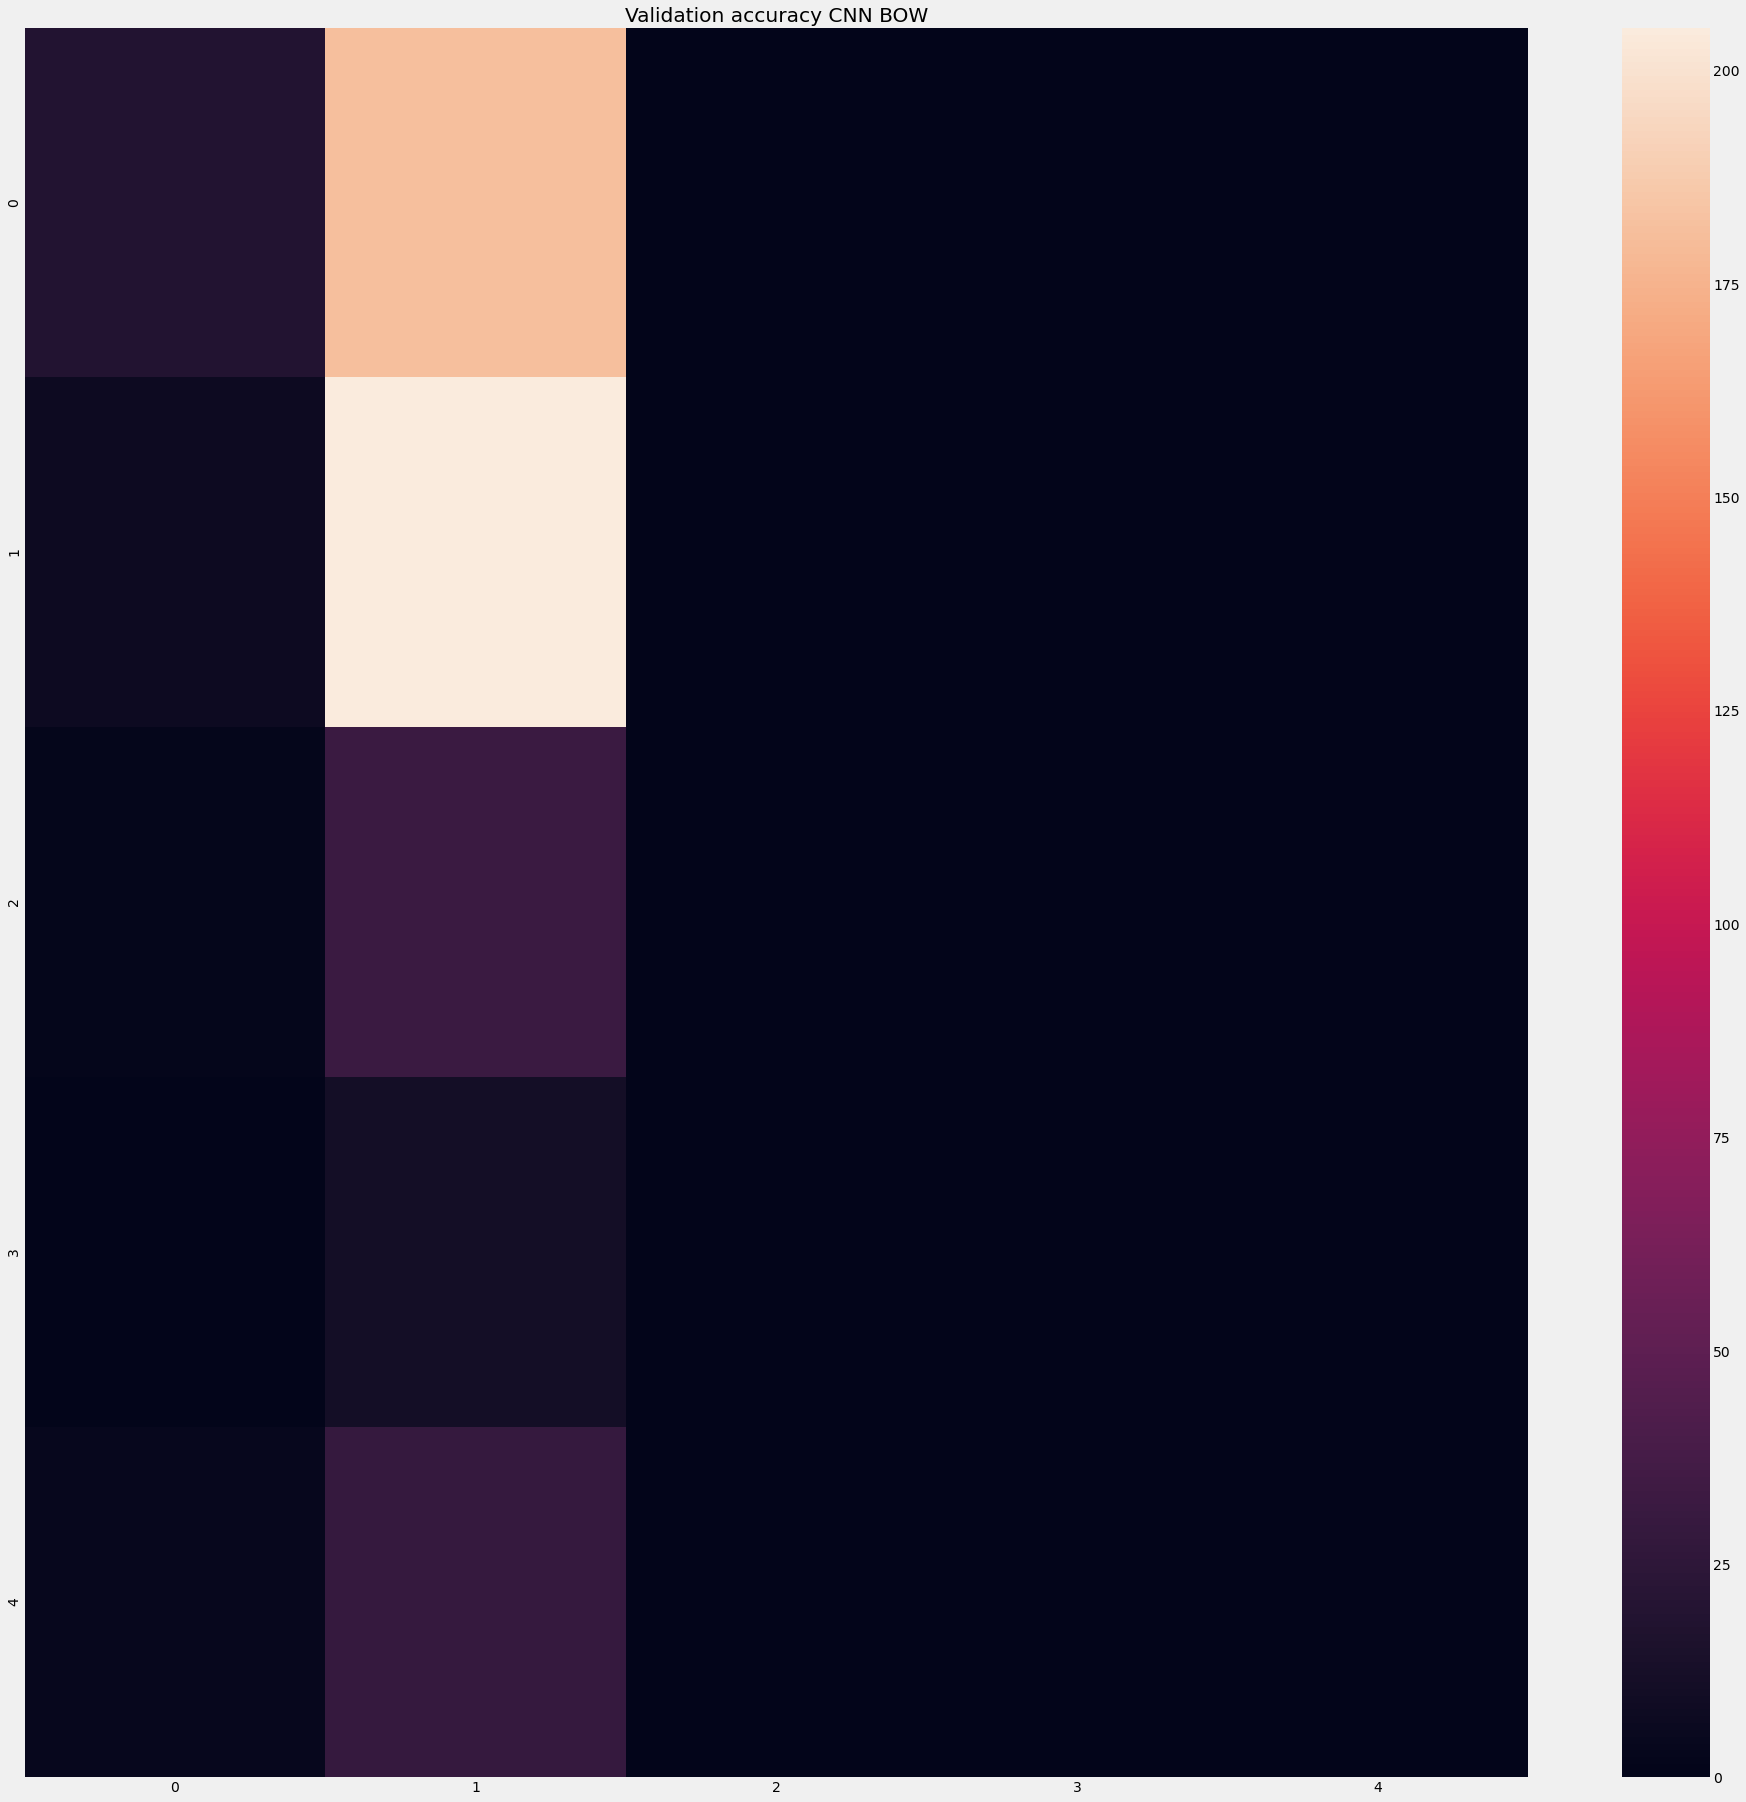

In [342]:
bow_predict_y_validation = CNN_BOW.predict(x_validation,verbose=1)
bow_predict_y_validation= encoder.inverse_transform(bow_predict_y_validation)
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y=None,y_predict=None,classes=None,name=None):
    plt.figure(figsize=(30, 30))
    sns.heatmap(confusion_matrix(y,y_predict), 
                xticklabels=classes,
                yticklabels=classes)
    plt.title(name)
    plt.show()
    
plot_confusion_matrix(y_valid,bow_predict_y_validation,encoder.classes_,'Validation accuracy CNN BOW')


* 맞춤법 검사의 시간을 줄이기 위해 count 먼저 줄이기

In [73]:
d = '아버지가방에들어가신다'
d1 = '아버지가 방에 들어가신다'

from konlpy.tag import Okt,Kkma, Komoran
okt = Okt()
kkma = Kkma()
komoran = Komoran()

print(okt.nouns(d))
print(okt.nouns(d1))

['아버지', '가방']
['아버지', '방']


In [74]:
print(komoran.nouns(d))
print(komoran.nouns(d1))

['아버지', '가방']
['아버지', '방']


In [75]:
print(kkma.nouns(d))
print(kkma.nouns(d1))

['아버지', '아버지가방', '가방']
['아버지', '방']


In [77]:
print(kkma.pos(d))
print(kkma.pos(d1))

[('아버지', 'NNG'), ('가방', 'NNG'), ('에', 'JKM'), ('들어가', 'VV'), ('시', 'EPH'), ('ㄴ다', 'EFN')]
[('아버지', 'NNG'), ('가', 'JKS'), ('방', 'NNG'), ('에', 'JKM'), ('들어가', 'VV'), ('시', 'EPH'), ('ㄴ다', 'EFN')]


### 맞춤법 검사

In [61]:
import json
import urllib
from bs4 import BeautifulSoup

def spellchecker(q):

    params = urllib.parse.urlencode({
        "_callback": "",
        "q": q
    })
    
    # 네이버 맞춤법 검사기 사용하여 문법 교정 
    data = urllib.request.urlopen("https://m.search.naver.com/p/csearch/ocontent/spellchecker.nhn?" + params)
    data = data.read().decode("utf-8")[1:-2]
    data = json.loads(data)
    data = data["message"]["result"]["html"]
    data = BeautifulSoup(data, "html.parser").getText()
    
    return data


def spellchecker_apply(content):
    i = 0
    j = 500

    content_lst = []

    if j>=len(content):
        content_lst = spellchecker(content)

    else:
        while j<len(content):

            content_lst.append(spellchecker(content[i:j]))

            i, j = j, j+500

            if j>=len(content):
                content_lst.append(spellchecker(content[i:len(content)]))

    return ''.join(content_lst)
        

In [65]:
import time
import random
i = 0
spell_end = []


for content in total['content']:
    
    spell_end.append(spellchecker_apply(content))  
    
    time.sleep(random.uniform(3,5))
    i += 1

    if i%350 == 0:
        time.sleep(random.uniform(50,70))
        print(i)

350


C:\Users\a0105\anaconda3\lib\site-packages\bs4\__init__.py:336: MarkupResemblesLocatorWarning: ".." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


700
1050
1400


C:\Users\a0105\anaconda3\lib\site-packages\bs4\__init__.py:336: MarkupResemblesLocatorWarning: "............" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


URLError: <urlopen error [WinError 10060] 연결된 구성원으로부터 응답이 없어 연결하지 못했거나, 호스트로부터 응답이 없어 연결이 끊어졌습니다>

In [ ]:
total['content_re'] = spell_end

In [ ]:
pd.DataFrame(spell_end).to_pickle("spell_content.pkl")

In [ ]:
total['doc_len'] = total['content_re'].apply(lambda words: len(words.split()))

In [ ]:
total['doc_len']

In [461]:
total_data = total[total['doc_len']>10]

In [462]:
total_data

,level_0,index,code,sdays,edays,title,count,content,category,progress,link,person,doc_len,range
0,125,125,543000,2019-03-01,2019-03-31,용인 D대학의 갑질을 고발합니다. 제 동생의 억울함을 풀수있도록 도와주세요!,1172,안녕하세요 저는 학생을 상대로 한 학교와 교수의 갑질로 인한 피해에 대한 도움을 구...,기타,청원종료,https://www1.president.go.kr/petitions/543000,"['청원인naver - ***', '']",593,0
1,126,180,543093,2019-03-01,2019-03-31,배출가스5등급차량운행제한에 대하여 청원합니다,451,배출가스 5등급 차량을 소유 운행하고 있는 사람입니다. 근래에 환경과 미세먼지에 대...,안전/환경,청원종료,https://www1.president.go.kr/petitions/543093,"['청원인naver - ***', '']",154,0
5,130,697,543864,2019-03-02,2019-04-01,신혼부부와 젊은이들이 거리로 쫓겨 나오게 되었습니다. - 부동산 사기,5636,경기도 안산시에 부동산 사기극이 발생하여 신혼부부와 젊은 청년들이 거리로 나오게 되...,행정,청원종료,https://www1.president.go.kr/petitions/543864,"['청원인facebook - ***', '']",425,0
7,133,957,544237,2019-03-02,2019-04-01,"미세먼지, 초미세먼지 강력하게 말하세요(feat. 중국발)",335,안녕하세요. 지금 이 청원을 쓰고 있는 순간도 화가 치밀어 오릅니다. 우리나라 국민...,안전/환경,청원종료,https://www1.president.go.kr/petitions/544237,"['청원인naver - ***', '']",246,0
8,134,1067,544391,2019-03-03,2019-04-02,가락시장 하역노동자 노동착취와 실태를 고발합니다,1218,저는 가락시장에서 몇 년째 하역노동자로 일합니다. 처음에 육체노동자의 한계를 생각하...,보건복지,청원종료,https://www1.president.go.kr/petitions/544391,"['청원인facebook - ***', '']",1482,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,13905,39999,596744,2021-03-02,2021-04-01,"살고싶어요, 살려주세요...",48750,"대통령님, 국민 여러분 도와주세요. 루게릭 병을 아십니까? 아이스버킷 챌린지 기억하...",보건복지,청원종료,https://www1.president.go.kr/petitions/596744,"['청원인naver - ***', '']",229,1
3446,13926,40030,596776,2021-03-03,2021-04-02,통영해양경찰서 직장 내 갑질로 예비남편이 사망하였습니다.,19524,통영해양경찰서에서 발생한 직장 내 괴롭힘으로 극단적인 선택을 한 예비남편의 죽음에 ...,인권/성평등,청원종료,https://www1.president.go.kr/petitions/596776,"['청원인naver - ***', '']",340,1
3447,13930,40034,596780,2021-03-03,2021-04-02,4차 재난지원금 집합제한업종에 매출비교는 너무 잔인하고 불공정합니다.,13170,오늘 기획재정부의 지원안이 발표 났습니다. 대부분 언론에서 보도했던 대로 나왔지만 ...,보건복지,청원종료,https://www1.president.go.kr/petitions/596780,"['청원인naver - ***', '']",194,1
3448,13932,40036,596782,2021-03-04,2021-04-03,소라넷 복사판인 '****'에 대한 수사를 '정석적으로' 진행하십시오.,96546,"백문이 불여일견입니다. 지금 당장, 아래의 링크를 클릭하셔서 실상을 보십시오. 청와...",인권/성평등,청원종료,https://www1.president.go.kr/petitions/596782,"['청원인naver - ***', '']",826,2


C:\Users\a0105\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


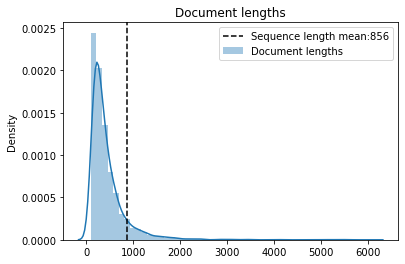

 가장 긴 문장은 6053 개의 단어를, 가장 짧은 문장은 95 개의 단어를 가지고 있습니다.


In [463]:

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.doc_len.mean() + dataframe.doc_len.std()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{max_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {total_data['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {total_data['doc_len'].min()} 개의 단어를 가지고 있습니다.")
plot_doc_lengths(total_data)

In [464]:
total[total['doc_len']<=10]

,level_0,index,code,sdays,edays,title,count,content,category,progress,link,person,doc_len,range
2,127,550,543636,2019-03-02,2019-04-01,2월 28일 KB증권 매도불가 현상,349,,경제민주화,청원종료,https://www1.president.go.kr/petitions/543636,"['청원인naver - ***', '']",0,0
3,128,610,543726,2019-03-02,2019-04-01,엄마의 마음으로 글을 올립니다 여사님 !,2321,,인권/성평등,청원종료,https://www1.president.go.kr/petitions/543726,"['청원인naver - ***', '']",0,0
4,129,695,543861,2019-03-02,2019-04-01,인천 구월동 원룸 살해사건 살인자의 거짓진술에 엄격한 처벌을 받을 수 있게 도와주세요.,3196,,인권/성평등,청원종료,https://www1.president.go.kr/petitions/543861,"['청원인naver - ***', '']",0,0
6,132,905,544176,2019-03-02,2019-04-01,sns포메폭행,439,,반려동물,청원종료,https://www1.president.go.kr/petitions/544176,"['청원인naver - ***', '']",0,0
10,137,1237,544670,2019-03-03,2019-04-02,한유총 특별법을 만들어야합니다.,1646,,육아/교육,청원종료,https://www1.president.go.kr/petitions/544670,"['청원인naver - ***', '']",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3430,13708,39733,596476,2021-02-16,2021-03-18,대구 주거밀집지역에 이슬람사원 건립 반대합니다.,10860,,교통/건축/국토,청원종료,https://www1.president.go.kr/petitions/596476,"['청원인kakao - ***', '']",0,1
3435,13808,39861,596605,2021-02-22,2021-03-24,의사뿐 아니라 국회의원.장관들 범법자들은 자격 박탈하게 해 주세요.,13347,,정치개혁,청원종료,https://www1.president.go.kr/petitions/596605,"['청원인naver - ***', '']",0,1
3436,13809,39862,596606,2021-02-22,2021-03-24,범죄저지른 의사 면허박탈 반대하는 의사협회 를 해산시켜주세요,13552,,보건복지,청원종료,https://www1.president.go.kr/petitions/596606,"['청원인naver - ***', '']",0,1
3440,13838,39902,596646,2021-02-24,2021-03-26,다문화 가정이란 이유로 제 친구를 폭행한 가해자들을 엄격하게 처벌해주세요,13639,,기타,청원종료,https://www1.president.go.kr/petitions/596646,"['청원인facebook - ***', '']",0,1
